### Background

A subscription-based product company launched a marketing campaign with the goal of increasing customer retention. Some customers were exposed to the marketing campaign while others were not. We are given a dataset that contains data at customer-level; the dataset contains information on customer demographics, some product-related behavioural metrics, a dichotomous variable to indicate whether customer was in "Treatment" (exposed to campaign) or "Control" (not exposed to campaign), and an "outcome" variable which is also a binary variable with outcome = 1 indicating that customer was retained and outcome = 0 indicating that customer was not retained.

### Business problem

Given this background, the task is to evaluate if the marketing campaign had a _**causal impact**_ on customer retention.<br><br>

At this point it is necessary to make the problem more precise. In the language of causal inference, what we seek is called "Treatment Effect". There are different kinds of treatment effects but the most important ones are Average Treatment Effect (ATE), Average Treatment Effect on the Treated (ATT), and Average Treatment Effect on the Untreated (ATU).<br>

Given the language of the instructions given to us -- _**".... identify if the marketing campaign had a causal impact on retention..."**_, it seems that we are asked to answer a question like - "Did the exposure to the marketing campaign cause an increase in retention?" Since the marketing campaign was shown only to the treated customers, by definition, the question is about estimating ATT.

The techniques that we use in this exercise can be used for both ATT and ATE. Therefore, we estimate both the quantities and present to the reader. However, since the recommendation that we have been asked to make pertains to campaign expansion, our focus will be on ATE, which also takes into account the untreated population.


### Solution approach<br>

Before we get into the weeds of the various modelling options to solve this problem, let's take a step back and think about what would be the most ideal scenario to answer this question in the easiest manner. If it were possible, what we would want to do is to give all the customers in our dataset the treatment and record their outcome. Then, we would want to go back in time, start over again and this time not give the treatment to any of the customers and record their outcome once again. Then we would calculate the percentage difference in the number of customers who were retained between the (hypothetical) scenarios and that would be our "Treatment Effect^".

Unfortunately, it is impossible to do this. The closest we can get to this ideal is through an experimental study based on Randomized Control Trials (RCTs) which are considered the gold standard when it comes to estimating causality**. 

Coming to the dataset at hand, the problem is about causal inferencing using data from an observational study. The biggest challenge in estimating causal effect from observational data is also what is called the "_fundamental problem of causal inference_". This problem refers to the fact that we observe each customer's outcome only under one scenario -- receive the treatment or not receive the treatment. We can never know the customer's outcome if they had not received the treatment (if they actually received it) and vice-versa. This alternative outcome is called the **counterfactual**. So the problem is that of missing counterfactual data. 

However, there _are_ some statistical techniques that we can use on our data to get reasonably good estimates of the causal impact of the marketing campaign.<br>
A prerequisite for every causal inference study, especially when using observational data is a _causal diagram_ (henceforth used interchangeably with  "Directed Acyclic Graph", or DAG).
A DAG is a visual device to guide our analyses. It is representation of the hypothesized relationships between variables. It shows which variables influence others and how they interact, helping to clarify our assumptions about the causal structure of your data.

First, let's look at the variables in our dataset:
- age: Continuous; The age of the customer.
- clv: Continuous; A value predicting how ‘valuable’ this customer is.
- segment: Categorical; The classification or customer segment based on subscription type.
- customer_engagement_score: Continuous; A score (0-100) representing the customer’s level of engagement with the product.
- treated: Binary; Indicates if the customer was exposed to the marketing campaign (0 = not exposed, 1 = exposed).
- outcome: Binary; Indicates customer retention after the campaign (0 = not retained, 1 = retained).
- subscription_length_months: Discrete; The duration (in months) of the customer’s subscription (max 36 months).
- income: Continuous; The annual income of the customer in dollars.
- life_phase: Categorical; Describes the customer’s life phase (e.g., married, pensioner, young parent).
- gender: Categorical; The gender of the customer.
- app_engagement_score: Continuous; A score (0-100) representing the customer’s app engagement level.


To understand the rationale behind the various relationships that are assumed to exist between these variables in this study, it is important to understand some fundamental categories that variables can belong to. These are:

- **Confounder:** a variable that affects both the treatment and the outcome, creating a spurious association between them. Confounders can bias the estimation of causal effects if not controlled.
    - To estimate unbiased causal effects, all observed confounders **should be** controlled for. This ensures that all "backdoor paths" from the treatment to outcome are blocked thereby giving the correlation between treatment and outcome a more causal interpretation.
 
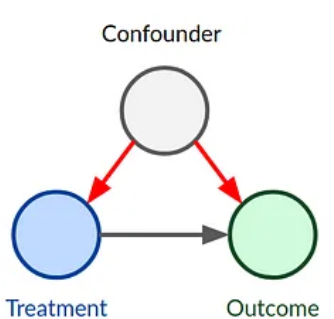
<br>

- **Collider:** a variable that is influenced by both the treatment and the outcome. Conditioning on a collider can induce a false association between the treatment and outcome.
    - To estimate unbiased causal effects, all observed colliders **should not be** controlled for. Controlling for them opens up the "backdoor path" from the treatment to the outcome which we intend to block. 
 
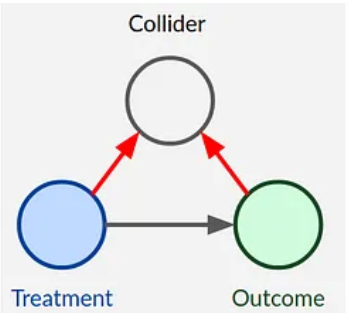
<br>

- **Mediator:** a variable that lies on the causal path between the treatment and the outcome. Mediators help explain how or why the treatment affects the outcome.
- **Moderator:** a variable that influences the strength or direction of the relationship between the treatment and the outcome. Moderators indicate when or under what conditions the treatment effect changes.


*********************************************
<font color = 'red'>**Solution specifications:**</font> 

- Our goal is to estimate whether "the marketing campaign had a causal impact on retention and to provide recommendations on whether to expand the campaign". In other words, we want to estimate the _average causal effect_ of the marketing campaign. The average causal effect, in the terminology of "potential outcomes" (Rubin, 2005) can be described as Average Treatment Effect (ATE) and is given by:
  $$ \text{ATE} = \mathbb{E}[Y(1) - Y(0)] $$
    
    - where the expectation E(.) is taken with respect to the target population.
    - Y(T) is the potential outcome value that would have been observed had the treatment been set to the specific value = T; in this case-study, T = 1 implies exposed to marketing campaign and T = 0 implies not exposed to marketing campaign.
    
- This ATE is a _marginal effect_ because it averages (marginalizes) over all individual-level effects in the population (Naimi, Cole, Kennedy, 2016). And since it is indifferent to individual-specific effects, it is well-suited as our object of interest. Thus, what we seek is the expected change in outcome (retention) when the whole population is given the treatment (ALL customers exposed to the marketing campaign) vs. when the whole population is not given the treatment (NO customer is exposed to the marketing campaign).
- For a robust causal analysis, we need to draw correct causal diagrams first. Domain knowledge is crucial in constructing any causal diagram. Due to lack of specific information regarding how 'retention' is defined and the basis for treatment decisions, we have made various assumptions in categorizing behavioural variables as confounders or colliders (but relying on data for such assumptions). This has led to multiple plausible causal diagrams (hence multiple models) and these will be explained later under the "Modelling" section.
- Given the number of covariates in our dataset, we would have liked to consider all the various permutations and combinations of assigning different behavioural variables as confounders/colliders/mediators/moderators. However, due to the paucity of time we consider only two scenarios which we considered to be most important:

    - Model 1: due to lack of theoretical background on treatment decision, we study a conservative, kitchen-sink model in which all covariates are considered as potential confounders and hence controlled for.
    - Model 2: a more selective model based on data-driven assumptions about which variables should and should not be controlled for.
    

- The justification behind these alternative scenarios and their respective DAGs is described in later cells.

********************************************

With that background, we begin our analyses. More details about modelling are provided under the "Modelling" section of this exercise.



<u>Footnotes</u>:<br>
^Specifically, this would measure the incremental retention effect of the treatment.<br>
**The specifics of how we would use a social experiment to answer this question are outlined in the PDF document accompanying this notebook.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)
pd.options.mode.chained_assignment = None

import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns

sns.set_style("darkgrid")
from tabulate import tabulate

import dowhy
from dowhy import CausalModel
import zepid
from zepid import load_sample_data, spline
from zepid.causal.gformula import TimeFixedGFormula

In [2]:
"""
LOAD DATA AND PREVIEW
"""

df = pd.read_csv("DS_data_challange.csv", sep=";")

In [3]:
print(f"There are {df.duplicated().sum()} duplicates in the dataset")

There are 0 duplicates in the dataset


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1337 non-null   int64  
 1   age                        1270 non-null   float64
 2   clv                        1270 non-null   float64
 3   segment                    1270 non-null   object 
 4   customer_engagement_score  1270 non-null   float64
 5   treated                    1270 non-null   float64
 6   outcome                    1270 non-null   float64
 7   subscription_length        1270 non-null   float64
 8   income                     1270 non-null   float64
 9   life_phase                 1270 non-null   object 
 10  gender                     1270 non-null   object 
 11  app_engagement_score       1270 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 125.5+ KB


In [5]:
df.head()

,Unnamed: 0,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score
0,0,58.0,52.0,Segment 3,41.0,1.0,1.0,26.0,69965.0,A,Female,8.0
1,1,43.0,77.0,Segment 3,85.0,0.0,0.0,22.0,77891.0,B,Female,61.0
2,2,41.0,NaN,Segment 2,85.0,NaN,0.0,28.0,69466.0,A,Female,NaN
3,3,41.0,100.0,Segment 1,9.0,0.0,0.0,1.0,71099.0,A,Male,77.0
4,4,89.0,0.0,Segment 2,9.0,0.0,0.0,2.0,50438.0,C,Female,65.0


#### Basic data preprocessing: missing values
From above preview of data we make the observation that all the columns have the exact same number of NaN values but they are scattered in different rows.<br>

This missing data will have to be handled in some way such as regression-based imputation or imputation based on mean/median/mode or dropping them entirely. We check how many clean rows we have (i.e. rows with not a single missing value in any column).

In [6]:
print(f"Total number of rows = {df.shape[0]}")
df = df[df.columns[1:]]
print(f"Rows without NaN values in ANY column = {df.dropna().shape[0]}")

Total number of rows = 1337
Rows without NaN values in ANY column = 756


We see that close to 50% of data has at least one missing value in at least one column.

Given the high percentage of missing data, it might not be prudent to drop these NaN rows rightaway, especially for the next step which is EDA, since we risk losing a lot of information and not getting an accurate picture of reality.


#### Basic data preprocessing: one-hot-encoding categorical variables

Converting categorical variables into one-hot-encoded features (plus some rudimentary preprocessing for ease-of-use)

In [7]:
df["segment"] = df["segment"].str.lower().str.replace(" ", "_")
df["life_phase"] = df["life_phase"].str.lower()
df["gender"] = df["gender"].str.lower()
dummies = pd.get_dummies(
    df[["segment", "life_phase", "gender"]],
    columns=["segment", "gender", "life_phase"],
    drop_first=False,
)
df = pd.concat([df, dummies], axis=1)
df[df.select_dtypes(include=["bool"]).columns] = df[
    df.select_dtypes(include=["bool"]).columns
].astype(int)
df.head()

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score,segment_segment_1,segment_segment_2,segment_segment_3,gender_female,gender_male,life_phase_a,life_phase_b,life_phase_c
0,58.0,52.0,segment_3,41.0,1.0,1.0,26.0,69965.0,a,female,8.0,0,0,1,1,0,1,0,0
1,43.0,77.0,segment_3,85.0,0.0,0.0,22.0,77891.0,b,female,61.0,0,0,1,1,0,0,1,0
2,41.0,NaN,segment_2,85.0,NaN,0.0,28.0,69466.0,a,female,NaN,0,1,0,1,0,1,0,0
3,41.0,100.0,segment_1,9.0,0.0,0.0,1.0,71099.0,a,male,77.0,1,0,0,0,1,1,0,0
4,89.0,0.0,segment_2,9.0,0.0,0.0,2.0,50438.0,c,female,65.0,0,1,0,1,0,0,0,1


#### Exploratory data analysis

Check the distribution of data across categorical variables and the average and median values for continuous variables.


In [8]:
cont_vars = [
    "customer_engagement_score",
    "age",
    "clv",
    "income",
    "subscription_length",
    "app_engagement_score",
]
cat_vars = ["outcome", "segment", "life_phase", "gender", "treated"]

for cat_var in cat_vars:
    print(cat_var)
    print(df[cat_var].value_counts(dropna=False), "\n")

outcome
0.0    942
1.0    328
NaN     67
Name: outcome, dtype: int64 

segment
segment_3    749
segment_1    289
segment_2    232
NaN           67
Name: segment, dtype: int64 

life_phase
b      458
c      410
a      402
NaN     67
Name: life_phase, dtype: int64 

gender
male      647
female    623
NaN        67
Name: gender, dtype: int64 

treated
0.0    1046
1.0     224
NaN      67
Name: treated, dtype: int64 



From the tables above we make the following observations:
- Data imbalance is not very severe in outcome variable.
- Majority of customers belong to _Segment 3_.
- Customers are almost evenly distributed in _gender_ and _life_phase_.
- Customers who got the treatment are in minority (~20% of untreated population)<br>


**Outlier detection**

In [9]:
"""
First, let's look at the descriptive statistics of continuous variables and then we chart distribution plots to check if there is any unusual skewness
that is immediately obvious
"""

df[cont_vars].describe()

,customer_engagement_score,age,clv,income,subscription_length,app_engagement_score
count,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000
mean,48.585039,49.849606,64.240945,61082.071654,17.949606,50.085039
std,28.831216,20.734774,33.796711,19775.230516,10.032837,28.475901
min,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000
25%,24.000000,34.000000,41.000000,49102.250000,9.000000,26.000000
50%,48.000000,47.000000,76.000000,64614.500000,18.000000,51.000000
75%,74.000000,62.000000,93.000000,76371.250000,26.000000,74.000000
max,99.000000,100.000000,100.000000,102800.000000,35.000000,99.000000



Distribution of continuous variables



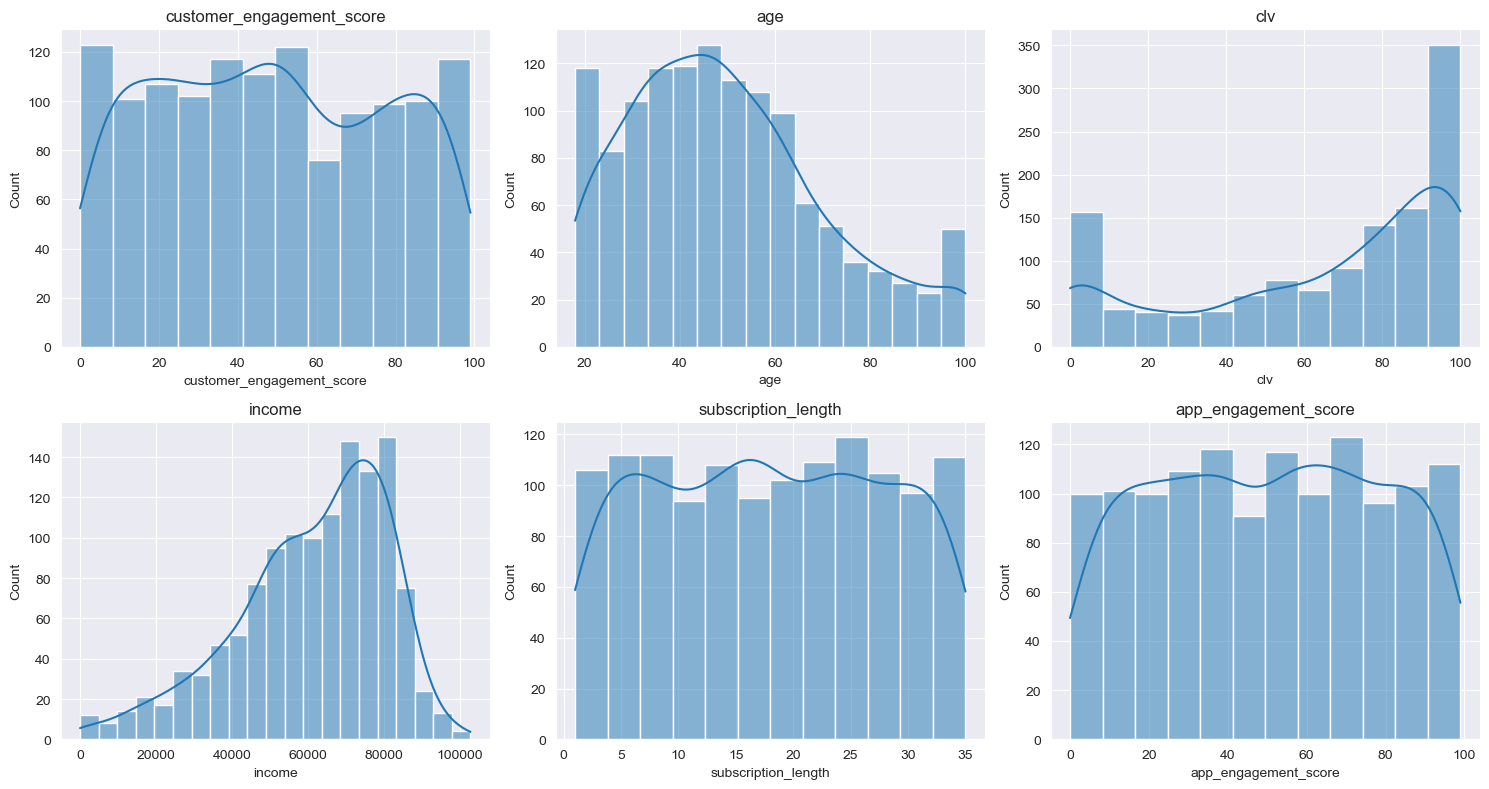

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

for i, var in enumerate(cont_vars):
    data = df[var].dropna()
    sns.histplot(data=data, kde=True, ax=ax[i])
    ax[i].set_title(var)

plt.tight_layout()
print("\nDistribution of continuous variables\n")
plt.show()

From the plots, we note that there are no unusual, visually detectable outliers that are immediately apparent.

However, two variables deserve a mention: _income_ and _clv_.

- _clv_ seems to be a little left-skewed, however, for the purposes of the analyses that we will be undertaking later on, _clv_ is going to be an irrelevant variable. Hence, we do not deep-dive into this issue.
- _income_ column contains some unusal entries such as zero income customers. Another unconvential observation is that income distribution in social sciences research is usually right-skewed but in this case-study it is slightly left-skewed. But perhaps this is because the company's customer base is composed of (relatively) higher-income people, in general.

In [11]:
"""
Let's count the number of "outliers" by income. We define outlier by the Inter-Quartile Range method.
Lower_bound = Quartile_1 - 1.5 * (Quartile_3 - Quartile_1)
Upper_bound = Quartile_3 + 1.5 * (Quartile_3 - Quartile_1)

Any customer with income < lower_bound or income > upper_bound is an outlier.

"""

q1 = np.quantile(df["income"].dropna(), 0.25)
q3 = np.quantile(df["income"].dropna(), 0.75)
lb = q1 - 1.5 * (q3 - q1)
ub = q3 + 1.5 * (q3 - q1)

income_outlier = df.query("(income < @lb) or (income > @ub)").shape[0]
print(f'Number of customers with "outlier" income: {income_outlier}')

Number of customers with "outlier" income: 17


Since this number is not unusally high, we err on the side of caution and do not drop these observations.

Furthermore, if these outlier customers contain NaN values in any other columns, they will be ignored from the modelling exercise as will be explained later under the "Modelling" section.

****************

**Identifying patterns or trends**<br>

Given the data imbalance in "treated", it might be of interest to compare the distribution of continuous variables between the treated vs. untreated customers.

This might give us some insights especially because it is not known how treatment decision was made.

In [12]:
"""
COMPARING mean AND median OF TREATED vs. NOT-TREATED GROUPS

"""

print("\nCOMPARING mean AND median OF TREATED vs. NOT-TREATED GROUPS\n")
df1 = df.query("treated == 1")[cont_vars].describe().loc[["mean", "50%"]].T
df2 = df.query("treated == 0")[cont_vars].describe().loc[["mean", "50%"]].T
df1.merge(
    df2,
    left_index=True,
    right_index=True,
    suffixes=["_of_treated_group", "_of_untreated_group"],
).round(2)


COMPARING mean AND median OF TREATED vs. NOT-TREATED GROUPS



,mean_of_treated_group,50%_of_treated_group,mean_of_untreated_group,50%_of_untreated_group
customer_engagement_score,33.94,31.0,51.41,52.0
age,45.64,43.0,51.08,48.0
clv,67.03,78.5,63.30,75.0
income,57715.93,60024.0,61880.17,65539.0
subscription_length,18.13,18.0,17.84,18.0
app_engagement_score,51.67,57.0,49.85,50.0


**KEY OBSERVATIONS (treated vs. untreated)**<br>
Treated customers seem to be **systematically different** from untreated customers:
- Treated customers have much lower average customer_engagement_score (~34 vs. ~51).
- Treated customers are younger on average (~46 vs. ~51).
- Treated customers have lower average income (~57K vs. ~62K).
- Treated customers have higher average clv (~67 vs. ~63).

(_whether statistically significant or not is checked later_)

The covariate imbalance observed here, as is expected in most observational studies, hints at the high likelihood that any association found between the treatment and the outcome may be biased by **selection effects** and **confounding variables**.

*************************

Next, we examine how the continuous variables differ (if at all) between customers that are retained (outcome = 1) vs. not_retained (outcome = 0).


In [13]:
"""
COMPARING mean AND median OF RETAINED vs. NOT-RETAINED GROUPS

"""

print("\nCOMPARING mean AND median OF RETAINED vs. NOT-RETAINED GROUPS\n")
df1 = df.query("outcome == 1")[cont_vars].describe().loc[["mean", "50%"]].T
df2 = df.query("outcome == 0")[cont_vars].describe().loc[["mean", "50%"]].T
df1.merge(
    df2,
    left_index=True,
    right_index=True,
    suffixes=["_of_retained_customers", "_of_NOT_retained_customers"],
).round(2)


COMPARING mean AND median OF RETAINED vs. NOT-RETAINED GROUPS



,mean_of_retained_customers,50%_of_retained_customers,mean_of_NOT_retained_customers,50%_of_NOT_retained_customers
customer_engagement_score,42.40,38.0,51.05,52.0
age,48.53,46.0,50.05,47.0
clv,68.91,81.0,62.92,74.0
income,66279.17,69514.0,59152.99,62838.0
subscription_length,16.83,16.0,18.32,18.0
app_engagement_score,55.50,58.0,48.35,48.0


**KEY OBSERVATIONS (Retained vs. Not_retained)**<br>
Indeed, from the table above we observe that:
- Customers that are retained have lower _customer_engagement_score_.
- Customers that are retained have higer _clv_.
- Customers that are retained have higer _income_.
- Customers that are retained have higer _app_engagement_score_.

(_whether statistically significant or not is checked later_)


In [14]:
"""
CHECK IF DIFFERENCES OBSERVED IN AVERAGE VALUES IS STATISTICALLY SIGNIFICANT

"""

for cat in ["treated", "outcome"]:
    if cat == "treated":
        print(
            "Variables with significant difference between Treated vs. Not_treated customers:"
        )
    elif cat == "outcome":
        print(
            "\nVariables with significant difference between Retained vs. Not_retained customers:"
        )

    c = 0
    for metric in cont_vars:
        positive_group = df[(df[cat] == 1) & (~df[metric].isna())][metric]
        negative_group = df[(df[cat] == 0) & (~df[metric].isna())][metric]
        u_stat, p_value = stats.mannwhitneyu(positive_group, negative_group)
        if p_value < 0.05:
            c = c + 1
            # print(f"U-statistic: {u_stat}")
            # print(f"P-value: {p_value}")
            print(f"{c}. {metric}")

Variables with significant difference between Treated vs. Not_treated customers:
1. customer_engagement_score
2. age
3. income

Variables with significant difference between Retained vs. Not_retained customers:
1. customer_engagement_score
2. clv
3. income
4. subscription_length
5. app_engagement_score


**************************
So far the analyses compared measures of central tendency. Next, to get a better picture of the whole distribution we compare boxplots for Treated/Untreated and Retained/Not_retained groups 

    


Compare distribution of RETAINED vs. NOT_RETAINED customers



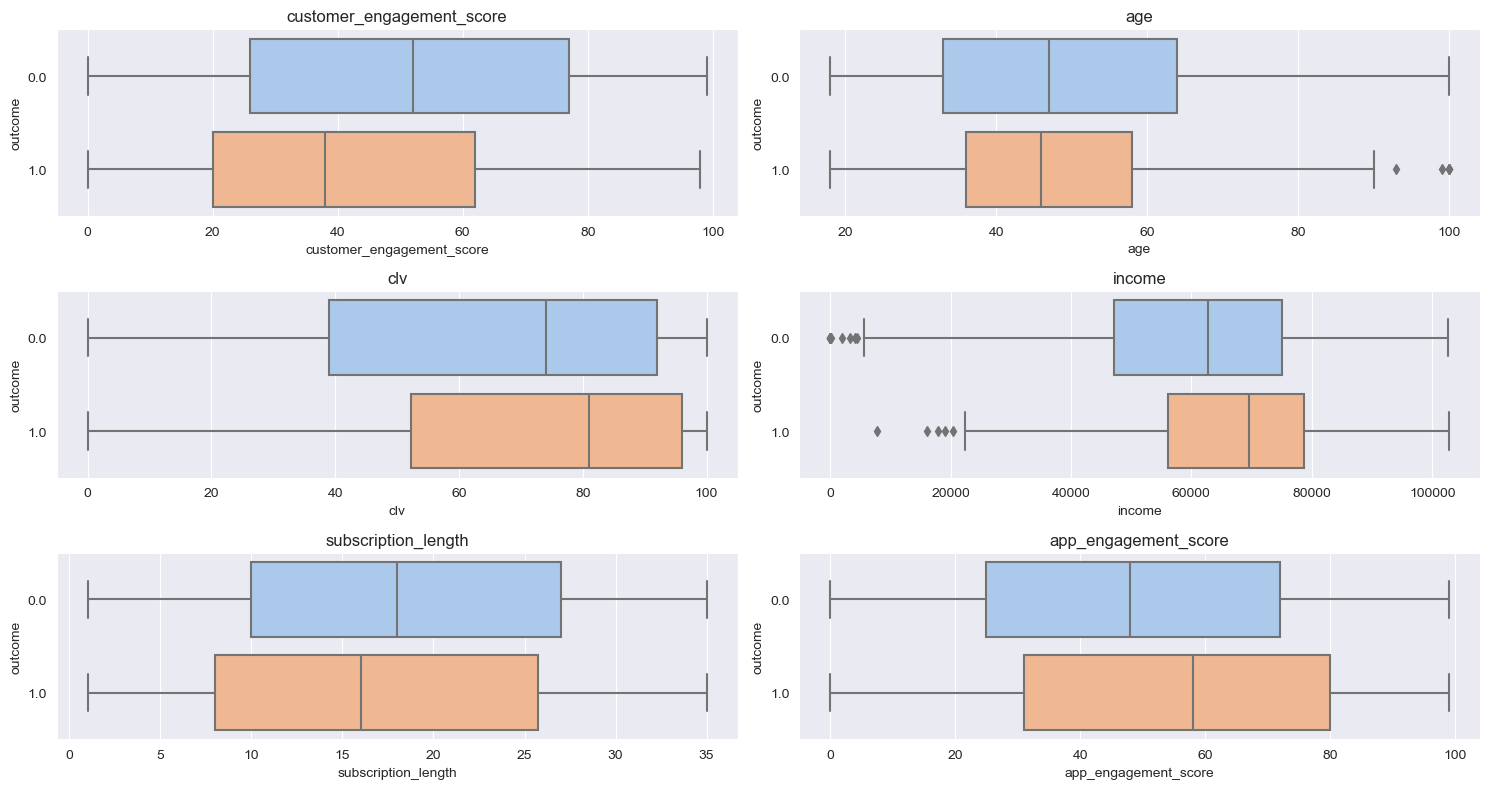

In [15]:
"""
COMPARE BOXPLOT OF ALL CONTINUOUS COVARIATES FOR outcome = 1 vs. outcome = 0

"""

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
ax = ax.flatten()
for i in range(len(ax)):
    data = df[(~df[cont_vars[i]].isna()) & (~df["outcome"].isna())]
    sns.boxplot(
        data=data,
        x=data[cont_vars[i]],
        y="outcome",
        orient="h",
        palette="pastel",
        ax=ax[i],
    )
    ax[i].set_title(cont_vars[i])

plt.tight_layout()
print("\nCompare distribution of RETAINED vs. NOT_RETAINED customers\n")
plt.show()


Compare distribution of TREATED vs. NOT_TREATED customers



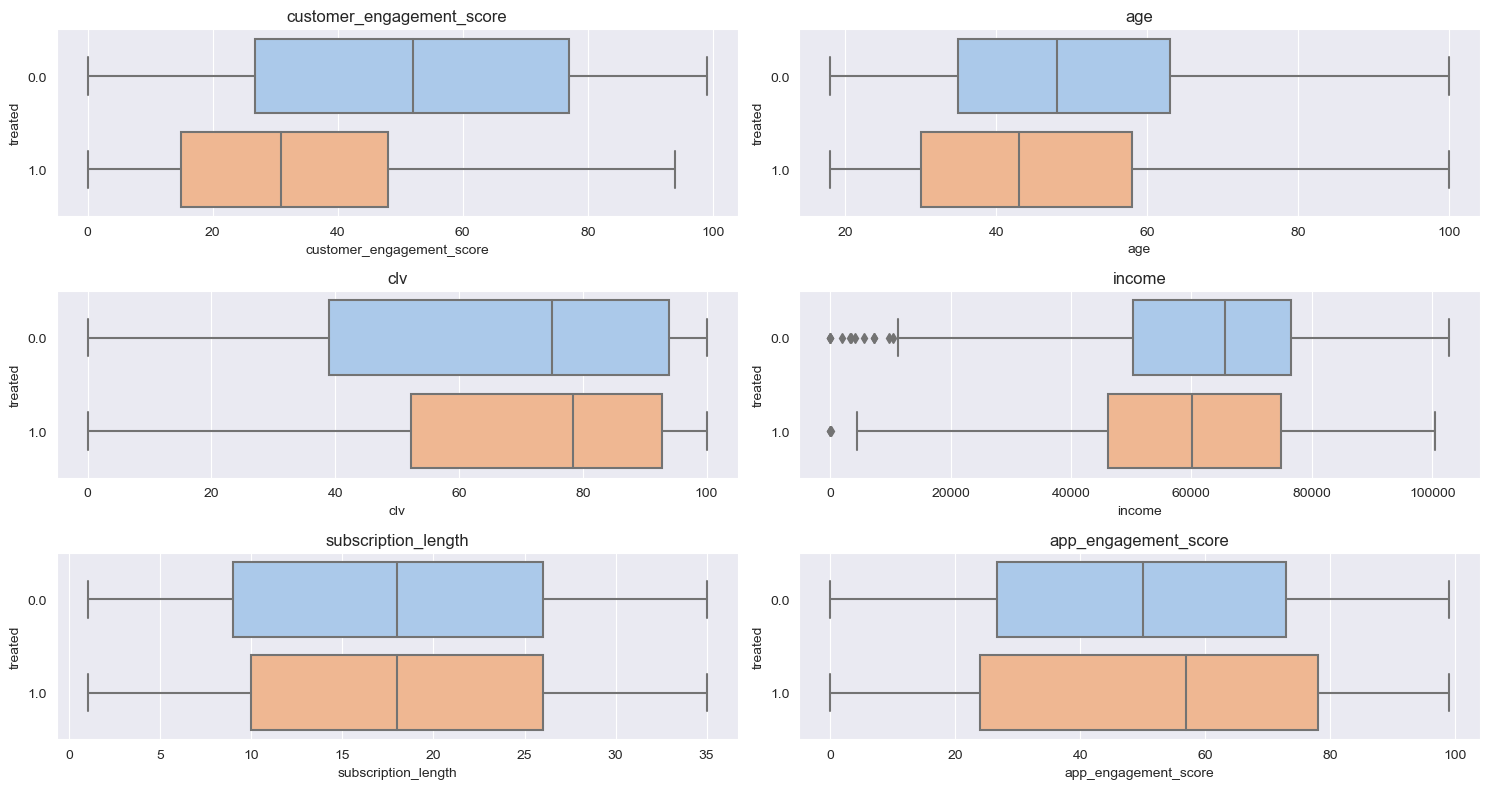

In [16]:
"""
COMPARE BOXPLOT OF ALL CONTINUOUS COVARIATES FOR treated = 1 vs. treated = 0

"""

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
ax = ax.flatten()
for i in range(len(ax)):
    data = df[(~df[cont_vars[i]].isna()) & (~df["treated"].isna())]
    sns.boxplot(
        data=data,
        x=data[cont_vars[i]],
        y="treated",
        orient="h",
        palette="pastel",
        ax=ax[i],
    )
    ax[i].set_title(cont_vars[i])

plt.tight_layout()
print("\nCompare distribution of TREATED vs. NOT_TREATED customers\n")
plt.show()

**KEY OBSERVATIONS (from above plots)**<br>

- We note that the behavioural variables (i.e. _app_engagment_score_, _customer_engagment_score_, _subscription_length_) have similar relative distributions for both treated = 1/0 as well as outcome = 1/0 customers.
- Therefore, it would be good to check if it is plausibile that we see this similar pattern because these three behavioural variables are confounding factors that influence both _treated_ and _outcome_ in the same way.
- To check for this let's look at the average values of these three behavioural metrics within each of the four _treated_ X _outcome_ levels (i.e., treated = 1, outcome = 1; treated = 1, outcome = 0; treated = 0, outcome = 1; treated = 0, outcome = 0).
- <font color = 'red'> **Important:**</font> the patterns that we observe in the charts below will dictate some assumptions about Model 2.

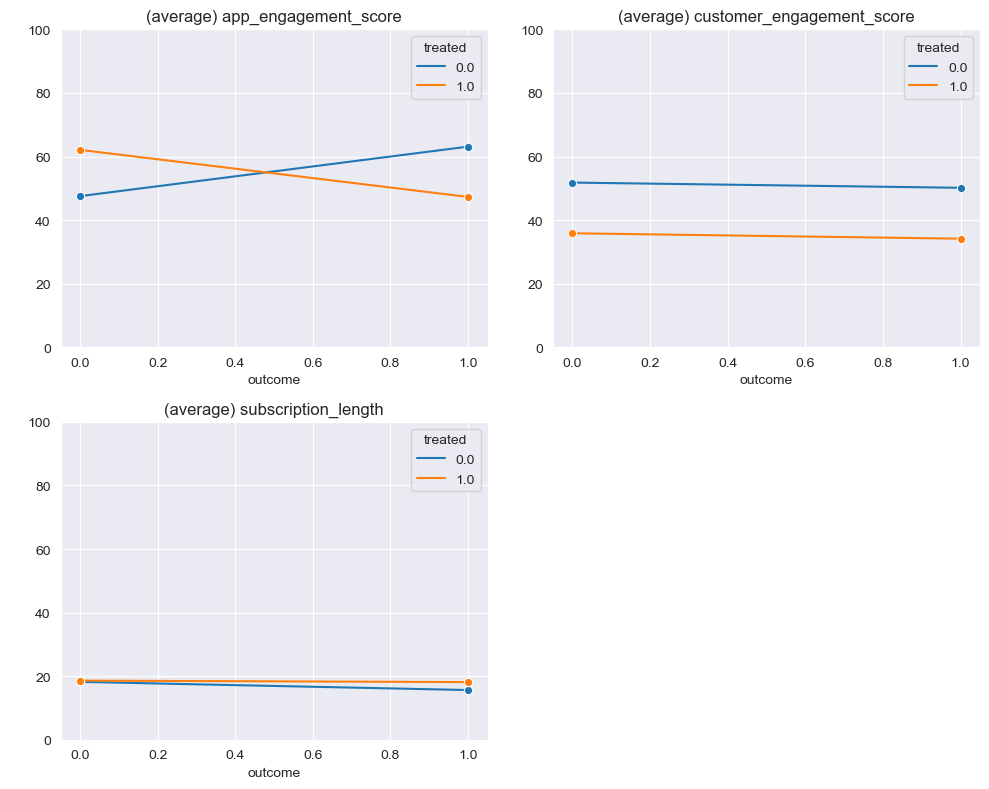

In [17]:
"""
SHOW AVERAGE VALUES OF THE 3 BEHAVIOURAL METRICS FOR THE 4 COMBINATIONS [(treated,outcome) = (1,1),(1,0),(0,1),(0,0)] 

"""

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = ax.flatten()
for i, metric in enumerate(
    ["app_engagement_score", "customer_engagement_score", "subscription_length"]
):
    cross_tab_data = df.dropna(subset=["treated", "outcome", metric])
    cross_tab_data = cross_tab_data.pivot_table(
        index="outcome", columns="treated", values=metric, aggfunc="mean"
    )

    cross_tab_data = cross_tab_data.reset_index()
    cross_tab_data_melt = cross_tab_data.melt(
        id_vars="outcome", value_vars=[0, 1], var_name="treated", value_name=metric
    )

    sns.lineplot(
        x="outcome",
        y=metric,
        hue="treated",
        marker="o",
        data=cross_tab_data_melt,
        ax=ax[i],
    )
    ax[i].set_ylim(0, 100)
    ax[i].set_ylabel(" ")
    ax[i].set_title(f"(average) {metric}")

fig.delaxes(ax[3])
plt.tight_layout()
plt.show()

**KEY ASSUMPTIONS (based on above plots)**<br>


- **app_engagement_score:**

  - Given that high app_engagement_score is defined as "more active participation and interaction with the app", we **assume** that retention would imply more opportunities for the customer to engage with the app hence leading to higher app_engagement_scores. Indeed, we see from the above plot for app_engagement_score that the natural (that is, without treatment) app_engagement_score for retained customers is quite high (top-right blue dot). Thus it is reasonable to assume that causality flows from the outcome (retention) to app_engagement_score. Thus, the assumption is basically about the temporal order of retention and app engagement.
 
  - On the treatment side also this assumption can be consistent by the following reasoning: first, note that the app_engagement_scores for treated-but-not-retained and not-treated-but-retained customers are almost the same (i.e., the top right blue dot and top left orange dot in the figure). Once the treatment is started and customers are exposed to the marketing campaigns, it is plausible that some of the previously naturally-high-engagement-customers, after receiving the treatment decided to reduce their app engagement to avoid those campaigns while some others decided to disengage entirely (hence outcome = 0 despite treated = 1). Note that for this story to be consistent we are once again making another assumption which is that the marketing campaign had a counterproductive effect on the average customer's behaviour and it was unappealing enough to lead to such behaviour^. Nonetheless, since we know nothing about the specifics of the campaign, we must make such assumptions/hypotheses and test them out with our models.
 
  - Thus, we see how both the treatment and outcome could potentially influence app_engagement_score, making it a potential **collider variable**, as shown in the DAG* below. **Model 2** will be based on this DAG.
    
    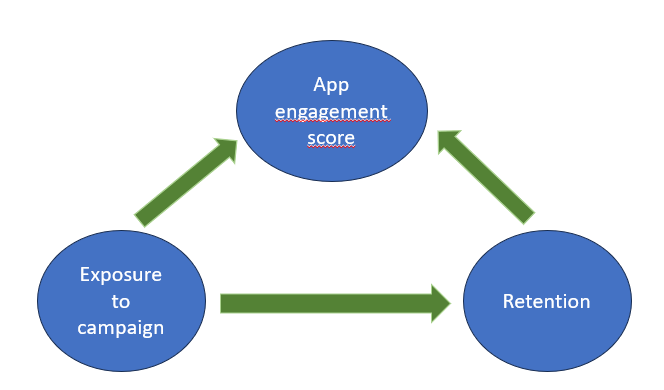

- **customer_engagement_score:**

  - Similar reasoning as in the case of app_engagement_score could be used to explain why customer_engagment_score could also potentially be a collider except the new addition that one reason for why treated-but-not-retained customers have low customer_engagement_scores but high app_engagement_score could simply be an artifact of how this score is defined, or maybe because it's easier to interact with the app than with the product.
 
- **subscription_length:**

    - We see that customers who saw the marketing campaign (treated = 1) AND were retained (outcome = 1) had slightly higher average subscription_length** than those who did not see the marketing campaign (treated = 0) but were retained (outcome = 1). Since the average subscription length is almost the same for treated and untreated customers who were not retained anyway, but slightly higher for customers who were retained and treated (exposed to marketing campaign), we **assume** that an increase in subscription_length follows retention. In other words, the assumption is that higher subscription length is just a natural byproduct of being with the company for a longer time (i.e., outcome = 1). So the assumption is about the temporal order of retention and subscription_length. Consequently, causality flows from retention to subscription_length in this assumption.
    - On the treatment side also, we **assume** that there is causality flowing from treatment to subscription_length by way of some third unobserved variable (such as, say, _"campaign appeal"_). It is plausible that depending on how appealing a customer finds the campaign that they are exposed to, they might increase their subscription length. Thus, if we are granted these two assumptions, then **"subscription_length" is a collider variable**, as shown in the figure below, and therefore, it must not be controlled for. This will also be a feature in **Model 2**.
      
    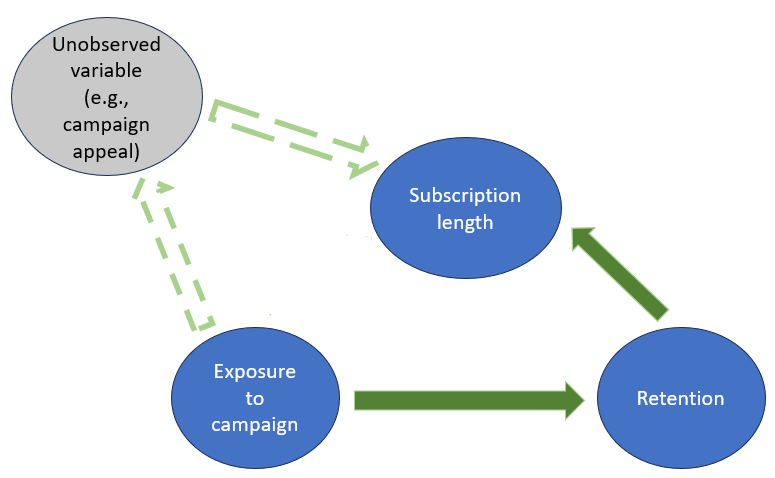


<br><br>

<u>Footnotes</u><br>
^This could happen, for instance, if some customers found the marketing campaigns annoying or repetitive. Their reaction might depend on various factors such as age, life phase, segment, or a combination of these, including unobserved factors. However, without specific information on the campaign's content, targeting strategy, or frequency, we cannot make any definitive conclusions. Therefore, while these are just speculations, they are still somewhat plausible.<br>
*This is not the complete DAG and it only shows these three variables of interest. Other variables are censored out for better readability.<br>
**A Mann-Whitney U test showed that the difference between roughly `subscription_length = 18` (for `treated = 1`; `outcome = 1`) and `subscription_length = 15` is significant at 5% level. 

************************
Next, check for patterns/systematic associations between categorical variables and 'outcome'
- First, we check (using Chi-squared test) if 'outcome' is meaningfully different across the various categorical_variables in the dataset.
- Next, we show contingency tables for the significant categorical variables and indicate how 'outcome' is distributed acorss the levels.

In [18]:
for main_var in ["treated", "outcome"]:
    for var in [x for x in cat_vars if x not in ["outcome"]]:
        if var == main_var:
            continue
        df_cleaned = df.dropna(subset=[var, main_var])
        contingency_table = pd.crosstab(df_cleaned[main_var], df_cleaned[var])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        if p < 0.05:
            print(f"significant association between '{main_var}' and '{var}'")
            # print(f"Expected Frequencies: \n{expected}")
            # print(f"P-value: {p.round(3)}")
            # print(f"Chi-squared Statistic: {chi2}")
            # print(f"Degrees of Freedom: {dof}")

significant association between 'treated' and 'segment'
significant association between 'treated' and 'gender'
significant association between 'outcome' and 'segment'
significant association between 'outcome' and 'gender'
significant association between 'outcome' and 'treated'


In [19]:
"""
CREATE CONTINGENCY TABLES

"""

for var in ["segment", "gender", "treated"]:
    df_cleaned = df.dropna(subset=[var, "outcome"])
    contingency_table_raw = pd.crosstab(df_cleaned["outcome"], df_cleaned[var])
    contingency_table = contingency_table_raw.div(contingency_table_raw.sum(axis=0)) * 100
    print(f"Contingency table: 'outcome' vs. '{var}' (in %)")
    print(
        tabulate(contingency_table, headers="keys", tablefmt="grid", floatfmt=".1f"),
        "\n",
    )

    chi2, p_value, _, _ = chi2_contingency(contingency_table_raw)
    print(f"Chi-Squared Test for 'outcome' vs. '{var}'")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"'outcome' and '{var}' are not independent.\n")
    else:
        print(f"'outcome' and '{var}' are independent.\n")
    print("****************************************************************")

Contingency table: 'outcome' vs. 'segment' (in %)
+-----------+-------------+-------------+-------------+
|   outcome |   segment_1 |   segment_2 |   segment_3 |
+===========+=============+=============+=============+
|       0.0 |        62.5 |        69.5 |        80.5 |
+-----------+-------------+-------------+-------------+
|       1.0 |        37.5 |        30.5 |        19.5 |
+-----------+-------------+-------------+-------------+ 

Chi-Squared Test for 'outcome' vs. 'segment'
P-value: 0.0000
'outcome' and 'segment' are not independent.

****************************************************************
Contingency table: 'outcome' vs. 'gender' (in %)
+-----------+----------+--------+
|   outcome |   female |   male |
+===========+==========+========+
|       0.0 |     76.5 |   70.3 |
+-----------+----------+--------+
|       1.0 |     23.5 |   29.7 |
+-----------+----------+--------+ 

Chi-Squared Test for 'outcome' vs. 'gender'
P-value: 0.0173
'outcome' and 'gender' are not inde

**********************
#### Main question: crux of this entire analysis

The striking observation made in the last contigency table of the cell above brings the main question of this exercise into clear focus: 72% of 'treated' customers are retained whereas only 16% of 'untreated' customers are retained. _**Does it mean that treatment causes retention**_?

Before we get down to answering that question using models, one last consideration is necessary: is it possible that exposure to the marketing campaign affects outcome differently for different subgroups of people? For example, does 'treatment' affect the propensity of retention for younger people differently than it does for older people, all else being equal?<br>
(what about income? or gender? or clv? etc.)

[_Earlier, we explored the three-way relationship between (treatment) X (outcome) X (customer characteristics) by examining the averages. Now, we are specifically investigating the presence of non-linear interactions within different subgroups of the sample (and potentially the broader population)._]

To get a preliminary peek into such potential interaction effects we plot below some interaction plots:


[NOTE: X-axis increases from 'cat_a' to 'cat_e' in all plots except 'gender' and 'segment']
[NOTE: y-axis indicates retention % in each category]



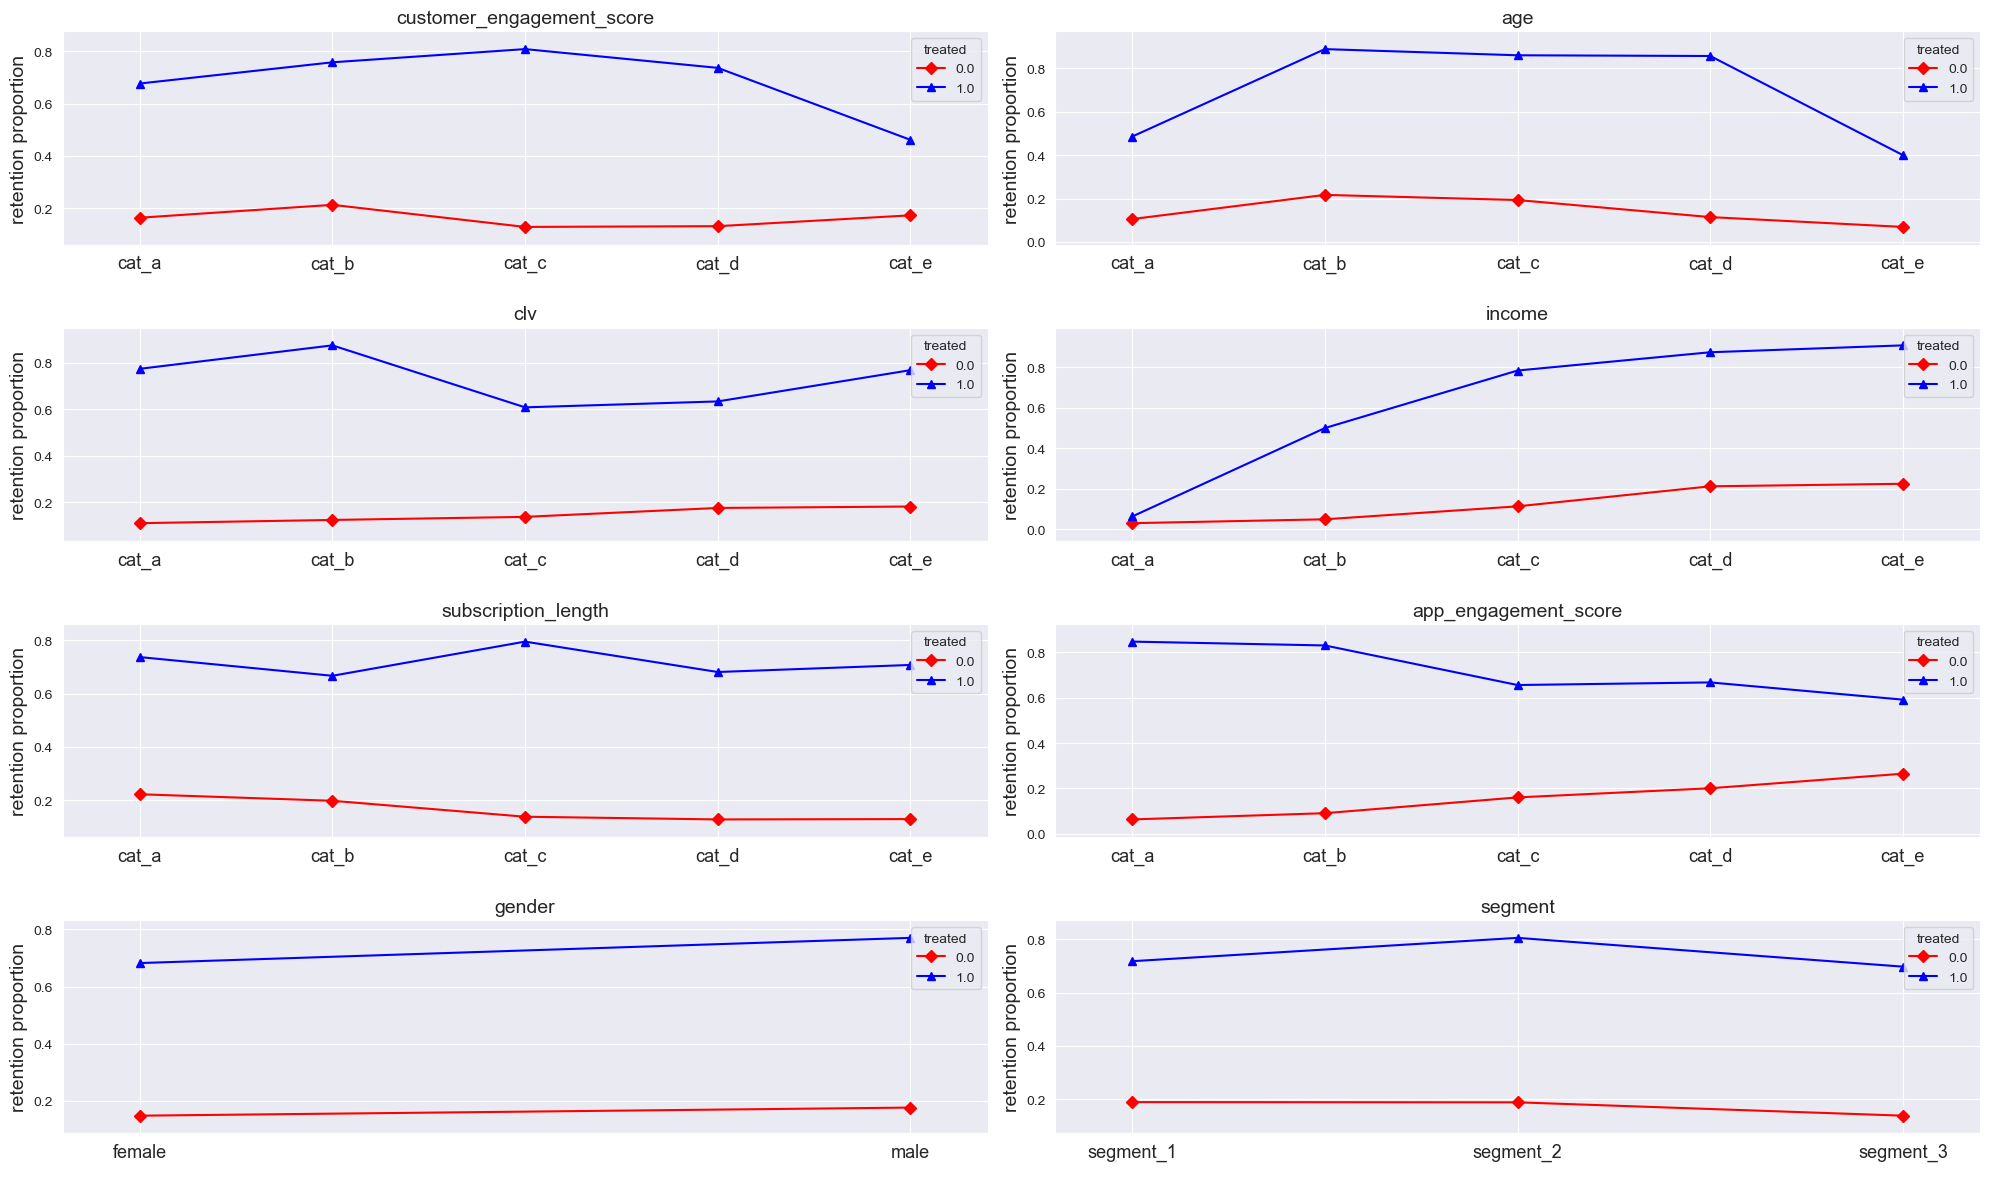

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))
ax = ax.flatten()

for i, var in enumerate(cont_vars + ["gender", "segment"]):
    df_clean = df.dropna(subset=["treated", "outcome", var])

    if var not in ["gender", "segment"]:
        df_clean[var + "_bins"] = pd.cut(
            df_clean[var],
            bins=5,
            labels=["cat_a", "cat_b", "cat_c", "cat_d", "cat_e"],
            include_lowest=True,  # Include the lowest value in the first bin
            ordered=True,  # Ensure the bins are treated as ordered
        )

        df_clean[var + "_bins"] = df_clean[var + "_bins"].astype(str)

        interaction_plot(
            x=df_clean[var + "_bins"],  # Binned continuous variable
            trace=df_clean["treated"],  # Treatment variable
            response=df_clean["outcome"],  # Binary outcome variable
            ax=ax[i],  # Subplot axis
            colors=["red", "blue"],  # Colors for each treatment group
            markers=["D", "^"],  # Markers for each treatment group
        )

    else:
        interaction_plot(
            x=df_clean[var],  # Binned continuous variable
            trace=df_clean["treated"],  # Treatment variable
            response=df_clean["outcome"],  # Binary outcome variable
            ax=ax[i],  # Subplot axis
            colors=["red", "blue"],  # Colors for each treatment group
            markers=["D", "^"],  # Markers for each treatment group
        )

    ax[i].set_title(f"{var}", fontsize=14)
    ax[i].set_ylabel(f"retention proportion", fontsize=14)
    ax[i].set_xlabel(" ")
    ax[i].set_xticklabels(labels=ax[i].get_xticklabels(), fontsize=13)

print(
    "\n[NOTE: X-axis increases from 'cat_a' to 'cat_e' in all plots except 'gender' and 'segment']"
)
print("[NOTE: y-axis indicates retention % in each category]\n")

plt.tight_layout()
plt.show()

##### **Interpreting above plots^**:

- In all the six plots the blue line (which indicates 'treated' customers) is always trending above the red line^^ implying that 'treated' customers have higher retention proportion (this was previously seen at a global level, but now we establish this trend within each customer characteristic as well).
- Furthermore, the two trend lines are not parallel in any of the six plots. This indicates presence of interaction effects, i.e., not only does treatment influence retention, but it influences it in a manner that depends on the level of a third variable (age, gender, income etc.).
- **Some key observations:**
    - _customer_engagement_score_: treatment is very effective for customers with low engagment but the effect becomes counterproductive for people with medium to high engagement.
    - _age_: treatment is definitely more effective than no-treatment, but the effect is not very strong if the customer is very young or very old.
    - _income_: the effect of treatment increases with levels of income -- higher the income, more effective the exposure to marketing campaign. 
    - _app_engagement_score_: treatment is effective but its effect decreases (monotonically) with increasing levels of app engagement.
    - _gender_: treatment seems to be more effective for males than females.
    - _segment_: treatment seems to be more effective for customers of segment 2 (as compared to segments 1 and 3).
    

^ continuous variables have been divided into 5 bins for better readability of charts.<br>
^^_only in the case of 'income' treatment seems to be insignificantly effective for very low income levels ('cat_a')_.

********************************
#### Modelling: theoretical background

Now that we have a satisfactory understanding of the various plausible relationships between the variables in our dataset, we can design our models based on these relationships. To reiterate some crucial points from the analyses done so far, recall that for any causal inference study from observational data, the first ingredient needed is a causal diagram (DAG). Since we do not have more information about how treatment exposure was decided, or how retention was defined, we made some assumptions about the relationships between the various covariates in this study. Given the number of covariates in our study there are many different permutations and combinations of inter-relationships that are possible. While it was not possible to consider all of them and analyse in detail, we chose two of them which were considered to be the most important:

 - Model 1: a model in which all covariates are considered as potential confounders and hence controlled for.
 - Model 2: a more selective model based on data-driven assumptions about which variables should and should not be controlled for.

<u>**DAG: Model 1**</u><br>

As shown in the figure below, Model 1 assumes that all the observable covariates are potential confounders to the effect of the treatment on the outcome.

Let's consider what it means and how the proposed confounding of variables can play out in real life:

- Age:
  - treatment: the company may have decided on the basis of age who gets the treatment and who does not. So clearly, age affects treatment status.
  - outcome: also very plausible that people may have different tendencies to be loyal to the product depending on their age (for example, if it is a dating app, then younger people might be more likely to keep using the app as compared to older customers). Therefore, age affects outcome also.
- Income:
  - treatment: the company may have decided on the basis of income who gets the treatment and who does not (for example, if the company has reason to believe, perhaps from another study, that affluent customers naturally tend to retain more then they might want to target low-income customers more.)
  - outcome: also plausible that income governs tendency to be retained (for example, in a parallel development, if the company increased their prices then affluent customers may be better able to accept the price hike whereas low-income customers may tend to dropout due to the financial strain.)
- Segment: the meaning of different segments is not clear but it is plausible that customer segment has a bearing on both treatment and outcome.
- Life phase:
  - treatment: it is plausible the company may have decided to target customers based on this demographic (for example, young parents, due to their busy lives might be less available to interact with the product/app and hence may be naturally more inclined to shear away).
  - outcome: as explained above.
- Gender:
  - treatment: it is plausible the company may have decided to target one gender over the other.
  - outcome: depending on the product, one gender may be more likely to be retained.<br>
- App/customer engagement:
  - treatment: it is plausible the company may have decided to target customers based on their app engagment.
  - outcome: it is plausible that app engagement is an early indicator of future retention status and hence it clearly affects the outcome.
- Subscription length:
  - treatment: it is plausible the company may have decided to target customers based on vintage (for example, newer customers might have a natural tendency to be retained due to novelty effect but older customers need continual enticement through marketing campaigns).
  - outcome: a retained customer will (by definition) have a longer subscription length.



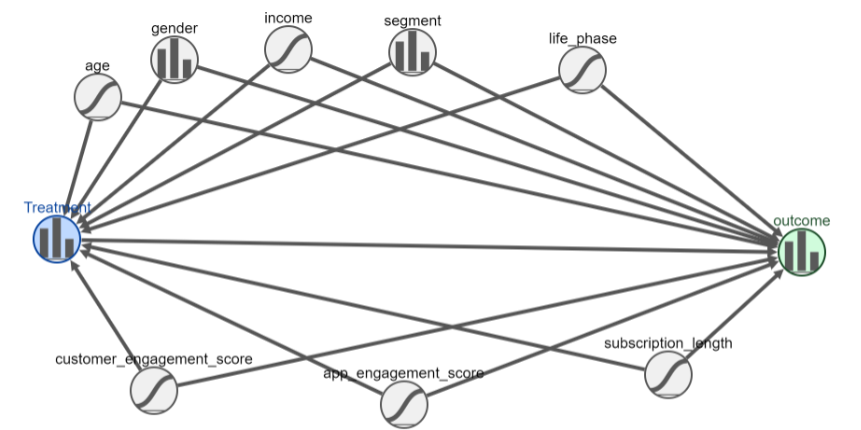

<br><br>

<u>**DAG: Model 2**</u>

As the figure shows, in this model only the customer's demographics are considered as confounders (reasoning remains the same as in Model 1). The other behavioural metrics of the customer (_app_engagement_score, _customer_engagement_score, _subscription_length_), with their arrowheads reversed in the figure below, are considered as colliders (as was explained earlier under "Key Assumptions" after cell number <font color = 'red'>**17**</font>. In the modelling exercise these behavioural metrics must not be controlled for.

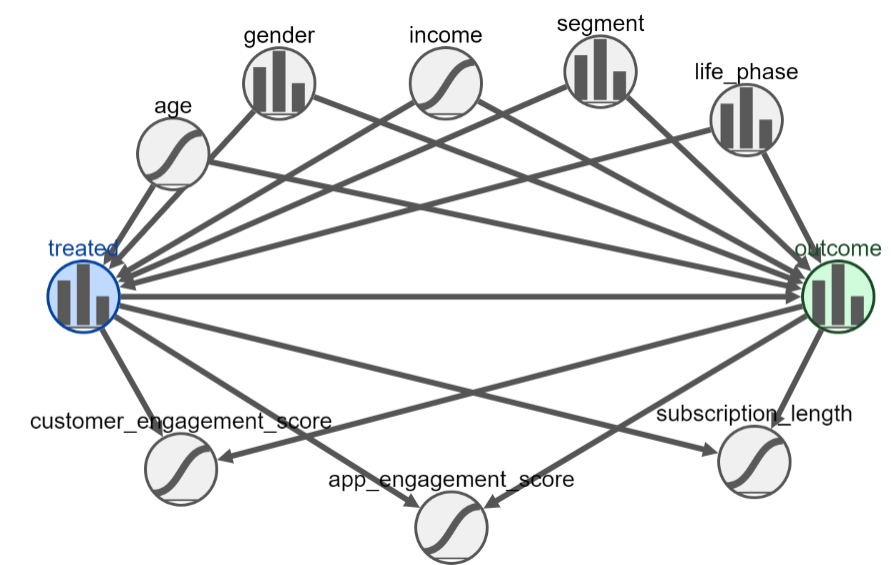



*******************************
<font color = 'red'>**NOTE**:</font> we have not considered _clv_ to be a confounder in any of the models because while it is possible that _clv_ influences treatment status, it does not seem very plausible that _clv_, which is a calculated and abstract metric could influence the decision to retain or not retain. And since a confounder, by definition, must influence both the treatment and outcome, _clv_ does not meet that criterion. That being said, it is of course possible that there is a third unobserved behavioural factor which "makes" a customer a high or low clv prospect, but we leave out that scenario in this analysis.

*******************************

#### Modelling: implementation**

We use two techniques to estimate the ATE (and ATT):

- **Propensity Score**: propensity score-based causal inference estimates treatment effects in observational studies by balancing covariates between treated and control groups. The propensity score represents the probability of receiving treatment based on observed variables. Key methods include matching, stratification, weighting, and covariate adjustment, helping reduce bias from confounding factors and enabling causal effect estimation.<br>
  
- **G-computation**: G-methods or G-computation is a causal inference technique that is widely used in epidemiology literature. It is a simple yet insightful technique that is especially useful when the objective is to estimate population-level marginal effects like in this case. The technique encompasses five main steps^:
  1) Use the observed data to fit a regression model with Y as outcome, X as treatment, and W as a vector of control variables.
  2) Create a new dataset exactly identical to the original data, but where X = 1 in every row (i.e., ALL customers given treatment).
  3) Create a new dataset exactly identical to the original data, but where X = 0 in every row (i.e., NO customer given treatment).
  4) Use the model from Step 1 to compute adjusted predictions in the two counterfactual datasets from Steps 2 and 3.
  5) The quantity of interest is the difference between the means of adjusted predictions in the two counterfactual datasets.



**************************

**Given our research question, what we are really seeking is a populative-wide _marginal effect_. Traditional methods for controlling confounding like a Linear Probability Model or Logistic Regression model would not be very useful in our case since the regression coefficients have a conditional interpretation which address questions about subgroups of the population, especially when there is potential for interaction between the treatment and a covariate as in this case study.<br><br>
^For the mathematical details of why this simple technique is so powerful we direct the reader to: (Naimi, A. I., Cole, S. R., & Kennedy, E. H. (2017). An introduction to g methods. International Journal of Epidemiology, 46(2), 756–762.)

#### Propensity-Score methods 
(applied to pruned dataset after dropping all NaN rows)

In [50]:
df_model = df.dropna()
df_model.shape

##### Model 1

In [22]:
# 1) DECLARE POTENTIAL CONFOUNDERS SPECIFIC TO THIS MODEL's DAG

potential_confounder = [
    "gender_male",
    "segment_segment_1",
    "segment_segment_3",
    "income",
    "age",
    "life_phase_a",
    "life_phase_b",
    "app_engagement_score",
    "customer_engagement_score",
    "subscription_length",
]

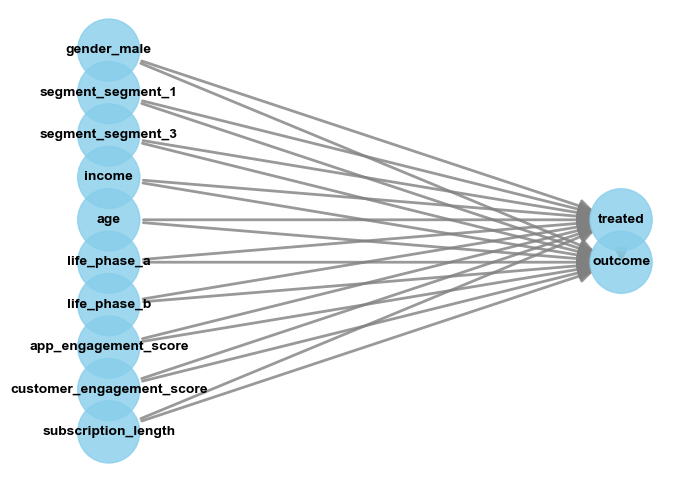

In [23]:
# CREATE MODEL OBJECT

model_1 = CausalModel(
    data=df_model,
    treatment="treated",
    outcome="outcome",
    common_causes=potential_confounder,
)

model_1.view_model()

In [24]:
# IDENTIFY EFFECT

identified_estimand = model_1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                                  ↪
──────────(E[outcome|income,segment_segment_3,age,customer_engagement_score,app_engagement_score,gender_male,life_phas ↪
d[treated]                                                                                                             ↪

↪                                                         
↪ e_a,life_phase_b,segment_segment_1,subscription_length])
↪                                                         
Estimand assumption 1, Unconfoundedness: If U→{treated} and U→outcome then P(outcome|treated,income,segment_segment_3,age,customer_engagement_score,app_engagement_score,gender_male,life_phase_a,life_phase_b,segment_segment_1,subscription_length,U) = P(outcome|treated,income,segment_segment_3,age,customer_engagement_score,app_engagement_score,gender

In [25]:
# ESTIMATE EFFECT

"""
We test out three methods for propensity-score based ATE estimation:
'Matching' pairs treated and control units with similar propensity scores to create balanced groups. 
'Stratification' divides the sample into strata based on propensity score ranges, then estimates treatment effects within each stratum. 
'Weighting' adjusts the contribution of each unit based on its propensity score to account for the likelihood of treatment, 
balancing the overall sample.

"""

methods = ["matching", "weighting", "stratification"]
desired_effect = "ate"
estimate_method = {}
estimate_value_dict = {}

for method in methods:
    estimate = model_1.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_" + method,
        target_units=desired_effect,
        confidence_intervals=True,
        test_significance=True,
    )
    estimate_method[method] = estimate
    estimate_value_dict[method] = np.round(estimate.value, 3)
    print("\n", f"Method: {method}")
    print(estimate, "\n")
    print(estimate.interpret())

estimate_value_dict


 Method: matching
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                                  ↪
──────────(E[outcome|income,segment_segment_3,age,customer_engagement_score,app_engagement_score,gender_male,life_phas ↪
d[treated]                                                                                                             ↪

↪                                                         
↪ e_a,life_phase_b,segment_segment_1,subscription_length])
↪                                                         
Estimand assumption 1, Unconfoundedness: If U→{treated} and U→outcome then P(outcome|treated,income,segment_segment_3,age,customer_engagement_score,app_engagement_score,gender_male,life_phase_a,life_phase_b,segment_segment_1,subscription_length,U) = P(outcome|treated,income,segment_

{'matching': 0.548, 'weighting': 0.59, 'stratification': 0.635}

In [27]:
# VALIDATION BY REFUTATION

"""
We validate the estimated result by using the following in-built "refuter" methods:
1) placebo_treatment_refuter: tests robustness by introducing a fake (placebo) treatment to verify if the estimated effect disappears, 
ensuring the observed effect is truly due to the real treatment.

2) random_common_cause: introduces random variables as common causes to check if unobserved confounders might 
bias the treatment effect, ensuring the model isn't overly sensitive to missing variables.

3) bootstrap_refuter tests the stability of the treatment effect by resampling the dataset multiple times (bootstrapping) 
and re-estimating the effect, ensuring the result is not overly dependent on the specific sample used.

IMPORTANT NOTE: we validate these methods on the most conservative estimate of ATE: 0.59 (estimated by propensity 'weighting' of observed data)

"""

for refuter_method in [
    "placebo_treatment_refuter",
    "random_common_cause",
    "bootstrap_refuter",
]:
    refuter = model_1.refute_estimate(
        identified_estimand,
        estimate_method["matching"],
        method_name=refuter_method,  # placebo_treatment_refuter
        placebo_type="permute",
    )
    print(refuter_method, "\n")
    print(refuter)

placebo_treatment_refuter 

Refute: Use a Placebo Treatment
Estimated effect:0.5476190476190477
New effect:0.0011640211640211637
p value:0.96

random_common_cause 

Refute: Add a random common cause
Estimated effect:0.5476190476190477
New effect:0.5476190476190477
p value:1.0

bootstrap_refuter 

Refute: Bootstrap Sample Dataset
Estimated effect:0.5476190476190477
New effect:0.558505291005291
p value:0.8200000000000001



**Discussion**<br>

- The Propensity Score estimation using the 'Matching' technique provides an Average Treatment Effect on the Treated (ATT) of 0.548, indicating that for the customers who were exposed to the marketing campaign, their probability of retention increased by 0.548 as a result of the campaign.

- The Propensity Score estimation using 'Weighting' or 'Stratification' shows an Average Treatment Effect (ATE) of 0.612, implying that if the marketing campaign were applied to the entire customer base, the probability of retention would increase, on average, by approximately 0.612.

- Placebo Treatment: Introducing a placebo treatment results in a new effect estimate of 0.0011, which is not significant (p-value = 0.96), suggesting that the originally estimated effect is a real treatment effect.

- Random Common Cause: Adding a random common cause as a potential confounder does not alter the original effect, indicating that the original estimate is robust to this additional variable. The associated p-value tests whether the difference between the new and old values is significant (it is not), reinforcing the stability of the original estimate.

- Bootstrapping: Performing bootstrapping on various samples from the original dataset also yields consistent results with the original estimated effect, further confirming the reliability and stability of the initial findings.

***************************
##### Model 2

In [51]:
# 1) DECLARE POTENTIAL CONFOUNDERS SPECIFIC TO THIS MODEL's DAG

"""Note that we removed the behavioural metrics as potential confounders.
"""

potential_confounder = [
    "gender_male",
    "segment_segment_1",
    "segment_segment_3",
    "income",
    "age",
    "life_phase_a",
    "life_phase_b",
]

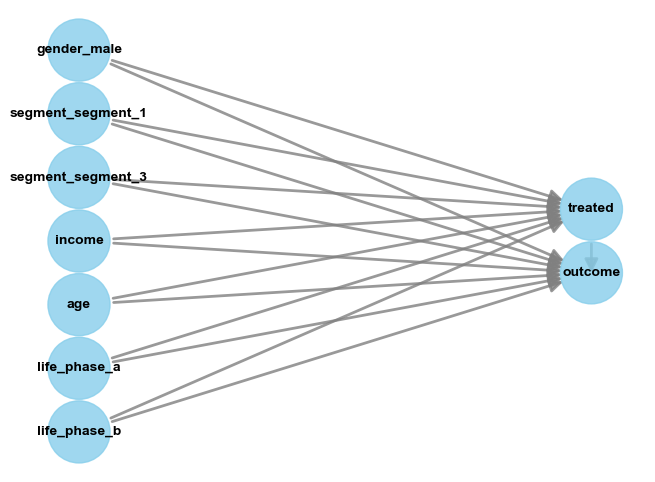

In [52]:
# CREATE MODEL OBJECT

model_2 = CausalModel(
    data=df_model,
    treatment="treated",
    outcome="outcome",
    common_causes=potential_confounder,
)

model_2.view_model()

In [53]:
# IDENTIFY EFFECT

identified_estimand = model_2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                      
──────────(E[outcome|income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1])
d[treated]                                                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treated} and U→outcome then P(outcome|treated,income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1,U) = P(outcome|treated,income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [54]:
# ESTIMATE EFFECT

"""
We test out three methods for propensity-score based ATE estimation:
'Matching' pairs treated and control units with similar propensity scores to create balanced groups. 
'Stratification' divides the sample into strata based on propensity score ranges, then estimates treatment effects within each stratum. 
'Weighting' adjusts the contribution of each unit based on its propensity score to account for the likelihood of treatment, 
balancing the overall sample.

"""

methods = ["matching", "weighting", "stratification"]
desired_effect = "ate"
estimate_method = {}
estimate_value_dict = {}

for method in methods:
    estimate = model_2.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_" + method,
        target_units=desired_effect,
        confidence_intervals=True,
        test_significance=True,
    )
    estimate_method[method] = estimate
    estimate_value_dict[method] = np.round(estimate.value, 3)
    print("\n", f"Method: {method}")
    print(estimate, "\n")
    print(estimate.interpret())

estimate_value_dict


 Method: matching
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                                                      
──────────(E[outcome|income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1])
d[treated]                                                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treated} and U→outcome then P(outcome|treated,income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1,U) = P(outcome|treated,income,segment_segment_3,age,gender_male,life_phase_a,life_phase_b,segment_segment_1)

## Realized estimand
b: outcome~treated+income+segment_segment_3+age+gender_male+life_phase_a+life_phase_b+segment_segment_1
Target units: ate

## Estimate
Mean value: 0.5992063492063493
p-value: [0, 0.001]
95.0%

{'matching': 0.599, 'weighting': 0.634, 'stratification': 0.605}

In [55]:
# VALIDATION BY REFUTATION

"""
We validate the estimated result by using the following in-built "refuter" methods:
1) placebo_treatment_refuter: tests robustness by introducing a fake (placebo) treatment to verify if the estimated effect disappears, 
ensuring the observed effect is truly due to the real treatment.

2) random_common_cause: introduces random variables as common causes to check if unobserved confounders might 
bias the treatment effect, ensuring the model isn't overly sensitive to missing variables.

3) bootstrap_refuter tests the stability of the treatment effect by resampling the dataset multiple times (bootstrapping) 
and re-estimating the effect, ensuring the result is not overly dependent on the specific sample used.

IMPORTANT NOTE: we validate these methods on the most conservative estimate of ATE: 0.605 (estimated by propensity 'stratification' of observed data)

"""

for refuter_method in [
    "placebo_treatment_refuter",
    "random_common_cause",
    "bootstrap_refuter",
]:
    refuter = model_2.refute_estimate(
        identified_estimand,
        estimate_method["matching"],
        method_name=refuter_method,  # placebo_treatment_refuter
        placebo_type="permute",
    )
    print("\n", refuter_method, "\n")
    print(refuter)


 placebo_treatment_refuter 

Refute: Use a Placebo Treatment
Estimated effect:0.5992063492063493
New effect:0.0077777777777777776
p value:0.8500000000000001


 random_common_cause 

Refute: Add a random common cause
Estimated effect:0.5992063492063493
New effect:0.5992063492063494
p value:1.0


 bootstrap_refuter 

Refute: Bootstrap Sample Dataset
Estimated effect:0.5992063492063493
New effect:0.6087830687830688
p value:0.8799999999999999



**Discussion**<br>

- The Propensity Score estimation using the 'Matching' technique provides an Average Treatment Effect on the Treated (ATT) of 0.599, indicating that for the customers who were exposed to the marketing campaign, their probability of retention increased by 0.599 as a result of the campaign.

- The Propensity Score estimation using 'Weighting' or 'Stratification' shows an Average Treatment Effect (ATE) of 0.615 (average of both), implying that if the marketing campaign were applied to the entire customer base, the probability of retention would increase, on average, by approximately 0.615.

- Placebo Treatment: Introducing a placebo treatment results in a new effect estimate of 0.0077, which is not significant (p-value = 0.85), suggesting that the originally estimated effect is a real treatment effect.

- Random Common Cause: Adding a random common cause as a potential confounder does not alter the original effect, indicating that the original estimate is robust to this additional variable. The associated p-value tests whether the difference between the new and old values is significant (it is not), reinforcing the stability of the original estimate.

- Bootstrapping: Performing bootstrapping on various samples from the original dataset also yields consistent results with the original estimated effect, further confirming the reliability and stability of the initial findings.

******************************************
#### G-computation 
(applied to pruned dataset after dropping all NaN rows)

We are using the open-source Zepid package for implementing G-computation. This package, by default, uses logistic regression on binary outcomes.
(https://zepid.readthedocs.io/en/latest/Reference/generated/zepid.causal.gformula.TimeFixed.TimeFixedGFormula.html)

In [56]:
df_model = df.dropna()
df_model.shape

##### Model 1

In [57]:
"""
1. Declare potential confounders
2. Create interaction terms
"""

potential_confounder = [
    "gender_male",
    "segment_segment_1",
    "segment_segment_3",
    "income",
    "age",
    "life_phase_a",
    "life_phase_b",
] + ["app_engagement_score", "customer_engagement_score"] + ["subscription_length"]

interaction = ["treated_" + x for x in potential_confounder]

for new_col in interaction:
    df_model[new_col] = df_model["treated"] * df_model[new_col.split("_", 1)[1]]

df_model.head()

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score,segment_segment_1,segment_segment_2,segment_segment_3,gender_female,gender_male,life_phase_a,life_phase_b,life_phase_c,treated_gender_male,treated_segment_segment_1,treated_segment_segment_3,treated_income,treated_age,treated_life_phase_a,treated_life_phase_b,treated_app_engagement_score,treated_customer_engagement_score,treated_subscription_length
0,58.0,52.0,segment_3,41.0,1.0,1.0,26.0,69965.0,a,female,8.0,0,0,1,1,0,1,0,0,0.0,0.0,1.0,69965.0,58.0,1.0,0.0,8.0,41.0,26.0
1,43.0,77.0,segment_3,85.0,0.0,0.0,22.0,77891.0,b,female,61.0,0,0,1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,41.0,100.0,segment_1,9.0,0.0,0.0,1.0,71099.0,a,male,77.0,1,0,0,0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.0,0.0,segment_2,9.0,0.0,0.0,2.0,50438.0,c,female,65.0,0,1,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,65.0,17.0,segment_3,26.0,0.0,0.0,17.0,61400.0,a,female,21.0,0,0,1,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# FOLLOW THE STEPS OF G-COMPUTATION

"""
Step 1) FIT A (Logistic) REGRESSION OF 'outcome' ON 'treated' + COVARIATES
"""

g = TimeFixedGFormula(df_model, exposure="treated", outcome="outcome")
g.outcome_model(model=" + ".join(["treated"] + potential_confounder + interaction))

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  756
Model:                            GLM   Df Residuals:                      734
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -288.46
Date:                Mon, 21 Oct 2024   Deviance:                       576.91
Time:                        12:39:16   Pearson chi2:                     789.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3246
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [59]:
"""
STEP 2) MAKE PREDICTIONS FOR 'outcome' WHEN ALL CUSTOMERS ARE GIVEN treated = 1 AND ESTIMATE AVERAGE 'outcome'
[for our binary outcome, this value can be interpreted as the average probability of retention; P(outcome = 1| treated = 1)]

"""

g.fit(treatment="all")
r_all = g.marginal_outcome
print(
    f"Under the scenario where all customers were exposed to the marketing campaign, the average probability of retention would have been: {r_all.round(3)}"
)

Under the scenario where all customers were exposed to the marketing campaign, the average probability of retention would have been: 0.865


In [60]:
"""
STEP 3) MAKE PREDICTIONS FOR 'outcome' WHEN ALL CUSTOMERS ARE GIVEN treated = 0 AND ESTIMATE AVERAGE 'outcome'
[for our binary outcome, this value can be interpreted as the average probability of retention; P(outcome = 1| treated = 0)]

"""

g.fit(treatment="none")
r_none = g.marginal_outcome
print(
    f"Under the scenario where no customers were exposed to the marketing campaign, the average probability of retention would have been: {r_none.round(3)}"
)

Under the scenario where no customers were exposed to the marketing campaign, the average probability of retention would have been: 0.14


In [61]:
"""
STEP 4) ESTIMATE MARGINAL EFFECT AS THE DIFFERENCE OF THE TWO MEANS
"""

print(
    f"Exposing all the customers of the company to the marketing campaign would increase the average probability of retention % by: {(r_all - r_none).round(3)}"
)
print("\n (this is the Average Treatment Effect)")

Exposing all the customers of the company to the marketing campaign would increase the average probability of retention % by: 0.726

 (this is the Average Treatment Effect)


In [62]:
"""
EXTRA STEP: ESTIMATE Average Treatment Effect on the Treated (ATT) 
"""

att = (
    df_model.query("treated == 1")["outcome"].mean()
    - g.predicted_df.query("treated == 0")["outcome"].mean()
)

print(
    f"By exposing some customers to the marketing campaign, "
    f"their probability of retention increased by : {att.round(3)}"
)

By exposing some customers to the marketing campaign, their probability of retention increased by : 0.598


In [63]:
"""
ESTIMATE CONFIDENCE INTERVAL (Bootstrap estimation)
"""

rd_results_m1 = []

for i in range(1000):
    s = df_model.sample(n=df_model.shape[0], replace=True)

    g = TimeFixedGFormula(s, exposure="treated", outcome="outcome")
    g.outcome_model(
        model=" + ".join(["treated"] + potential_confounder + interaction),
        print_results=False,
    )

    g.fit(treatment="all")
    ra = g.marginal_outcome
    g.fit(treatment="none")
    rn = g.marginal_outcome
    rd_results_m1.append(ra - rn)

print(f"95% LCL: {np.percentile(rd_results_m1,q = 2.5).round(3)}")
print(f"95% UCL: {np.percentile(rd_results_m1,q = 97.5).round(3)}")

95% LCL: 0.172
95% UCL: 0.832


In [64]:
print(f"Mean ATE estimate: {pd.Series(rd_results_m1).describe().loc['mean'].round(3)}")
print(f"Standard error: {pd.Series(rd_results_m1).describe().loc['std'].round(3)}")

Mean ATE estimate: 0.661
Standard error: 0.175


**Discussion**<br>

- The outcome regression indicates that the treatment coefficient is positive and significant, suggesting that exposure to the marketing campaign positively and significantly impacts the conditional probability of retention, although the interpretation of its coefficient is in log-odds rather than a straightforward linear interpretation.

- If all customers were exposed to the marketing campaign, the average probability of retention would be 0.865.

- Conversely, if no customers were exposed to the campaign, the average probability of retention would drop to 0.14.

- Exposing all customers to the marketing campaign would increase the average probability of retention by 0.726 (ATE).

  - Bootstrapped mean ATE = 0.661 (close to the PS ATE estimate of 0.612)
  - Boostrapped std (standard error) = 0.175

- For customers who were actually exposed to the marketing campaign, their probability of retention increased by 0.598 (ATT).

- The 95% confidence interval (CI) for the ATE estimate is [0.172, 0.832], which does not include zero, indicating that the treatment would have a significant positive impact on retention if implemented across the entire population.

***************************
##### Model 2

In [42]:
df_model = df.dropna()
df_model.shape

In [43]:
"""
1. Declare potential confounders
2. Create interaction terms
"""

potential_confounder = [
    "gender_male",
    "segment_segment_1",
    "segment_segment_3",
    "income",
    "age",
    "life_phase_a",
    "life_phase_b",
]

interaction = ["treated_" + x for x in potential_confounder]

for new_col in interaction:
    df_model[new_col] = df_model["treated"] * df_model[new_col.split("_", 1)[1]]

df_model.head()

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score,segment_segment_1,segment_segment_2,segment_segment_3,gender_female,gender_male,life_phase_a,life_phase_b,life_phase_c,treated_gender_male,treated_segment_segment_1,treated_segment_segment_3,treated_income,treated_age,treated_life_phase_a,treated_life_phase_b
0,58.0,52.0,segment_3,41.0,1.0,1.0,26.0,69965.0,a,female,8.0,0,0,1,1,0,1,0,0,0.0,0.0,1.0,69965.0,58.0,1.0,0.0
1,43.0,77.0,segment_3,85.0,0.0,0.0,22.0,77891.0,b,female,61.0,0,0,1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,41.0,100.0,segment_1,9.0,0.0,0.0,1.0,71099.0,a,male,77.0,1,0,0,0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.0,0.0,segment_2,9.0,0.0,0.0,2.0,50438.0,c,female,65.0,0,1,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,65.0,17.0,segment_3,26.0,0.0,0.0,17.0,61400.0,a,female,21.0,0,0,1,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# FOLLOW THE STEPS OF G-COMPUTATION

"""
Step 1) FIT A (LOGISTIC) REGRESSION OF 'outcome' ON 'treated' + COVARIATES
"""

g = TimeFixedGFormula(df_model, exposure="treated", outcome="outcome")
g.outcome_model(model=" + ".join(["treated"] + potential_confounder + interaction))

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  756
Model:                            GLM   Df Residuals:                      740
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -308.89
Date:                Mon, 21 Oct 2024   Deviance:                       617.79
Time:                        10:53:40   Pearson chi2:                     758.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2871
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercep

In [45]:
"""
STEP 2) MAKE PREDICTIONS FOR 'outcome' WHEN ALL CUSTOMERS ARE GIVEN treated = 1 AND ESTIMATE AVERAGE 'outcome'
[for our binary outcome, this value can be interpreted as the average probability of retention; P(outcome = 1| treated = 1)]
"""

g.fit(treatment="all")
r_all = g.marginal_outcome
print(
    f"Under the scenario where all customers were exposed to the marketing campaign, the average probability of retention would have been: {r_all.round(3)}"
)

Under the scenario where all customers were exposed to the marketing campaign, the average probability of retention would have been: 0.675


In [46]:
"""
STEP 3) MAKE PREDICTIONS FOR 'outcome' WHEN ALL CUSTOMERS ARE GIVEN treated = 0 AND ESTIMATE AVERAGE 'outcome'
[for our binary outcome, this value can be interpreted as the average probability of retention; P(outcome = 1| treated = 0)]

"""

g.fit(treatment="none")
r_none = g.marginal_outcome
print(
    f"Under the scenario where no customers were exposed to the marketing campaign, the average probability of retention would have been: {r_none.round(3)}"
)

Under the scenario where no customers were exposed to the marketing campaign, the average probability of retention would have been: 0.178


In [47]:
"""
STEP 4) ESTIMATE MARGINAL EFFECT AS THE DIFFERENCE OF THE TWO MEANS
"""

print(
    f"Exposing all the customers of the company to the marketing campaign would increase the average probability of retention % by: {(r_all - r_none).round(3)}"
)
print("\n (this is the Average Treatment Effect)")

Exposing all the customers of the company to the marketing campaign would increase the average probability of retention % by: 0.497

 (this is the Average Treatment Effect)


In [48]:
"""
EXTRA STEP: ESTIMATE Average Treatment Effect on the Treated (ATT) 
"""

att = (
    df_model.query("treated == 1")["outcome"].mean()
    - g.predicted_df.query("treated == 0")["outcome"].mean()
)

print(
    f"By exposing some customers to the marketing campaign, "
    f"their probability of retention increased by : {att.round(3)}"
)

By exposing some customers to the marketing campaign, their probability of retention increased by : 0.559


In [49]:
"""
ESTIMATE CONFIDENCE INTERVAL (Bootstrap estimation)
"""

rd_results_m2 = []

for i in range(1000):
    s = df_model.sample(n=df_model.shape[0], replace=True)

    g = TimeFixedGFormula(s, exposure="treated", outcome="outcome")
    g.outcome_model(
        model=" + ".join(["treated"] + potential_confounder + interaction),
        print_results=False,
    )

    g.fit(treatment="all")
    ra = g.marginal_outcome
    g.fit(treatment="none")
    rn = g.marginal_outcome
    rd_results_m2.append(ra - rn)

print(f"95% LCL: {np.percentile(rd_results_m2,q = 2.5).round(3)}")
print(f"95% UCL: {np.percentile(rd_results_m2,q = 97.5).round(3)}")

95% LCL: -0.057
95% UCL: 0.807


**Discussion**<br>

- The outcome regression indicates that the treatment coefficient is positive but not significant at the 5% level, meaning the null hypothesis of no effect cannot be rejected at this significance level; however, it can be rejected at the 10% level, suggesting a marginally positive effect.

- If all customers were exposed to the marketing campaign, the average probability of retention would be 0.675.

- Conversely, if no customers were exposed to the campaign, the average probability of retention would decline to 0.178.

- Exposing all customers to the marketing campaign would increase the average probability of retention by 0.497 (ATE).

- For customers who were actually exposed to the marketing campaign, their probability of retention increased by 0.559 (ATT).

- The 95% confidence interval (CI) for the ATE estimate is [-0.057, 0.807], which includes zero, indicating that the estimated effect of the treatment may not be statistically significant, and potentially even that the causal structure assumed for this model is not true.

******************************

#### Conclusion

In this exercise, we assessed the causal impact of the marketing campaign on customer retention by estimating both the Average Treatment Effect (ATE) and the Average Treatment Effect on the Treated (ATT). Given the ambiguity surrounding the definitions of retention and treatment decisions, we formulated assumptions about the relationships between covariates, resulting in two proposed models: Model 1, which treats all observed covariates as confounders, and Model 2, which considers some covariates as colliders.

We applied two analytical techniques—Propensity Score (PS) and G-computation—to both models. To handle missing data, we assumed it was Missing At Random (MAR) and removed all rows with any missing values. Both methods indicated a significant positive treatment effect for Model 1, whereas PS produced significant results for Model 2, but G-computation did not. Additionally, the ATE estimate for Model 2 was highly imprecise, as indicated by a wide 95% confidence interval. Consequently, we favor Model 1, suggesting that its Directed Acyclic Graph (DAG) is more realistic and highlights the importance of customer behavioral metrics (such as app engagement, customer engagement, and subscription length) in influencing retention outcomes.

The ATT estimates were 0.548 from PS and 0.598 from G-computation. The ATE estimates were 0.612 for PS and 0.726 for G-computation. The discrepancy in ATE can be attributed to PS's reliance on actual observed data, whereas G-computation's predictions introduce complexity due to its enforced non-linear relationships via logistic regression. Thus, we recommend relying on the estimates derived from the PS method for actionable insights.

Moreover, the G-computation regression uncovered that treatment interacts significantly with app engagement in a negative fashion, suggesting diminishing returns for customers with high app engagement when exposed to the campaign. Additionally, treatment appeared to be more effective for males than females, although this finding lacks statistical significance (p-value = 0.584).

A limitation of this analysis is the exclusion of rows with missing data, which may have led to a loss of valuable information. Furthermore, G-computation’s reliance on logistic regression imposes a parametric relationship between the outcome and independent variables, introducing potential model misspecification. In future analyses, we intend to explore "super learners," leveraging diverse machine learning algorithms to enhance predictive modeling, including non-parametric methods like decision trees.

Lastly, we opted not to include Customer Lifetime Value (CLV) in our analysis, reasoning that it is an internal metric and does not directly affect retention. However, if CLV influences treatment decisions, this raises the possibility of using CLV as an instrumental variable for causal inference—an area we plan to investigate in future research.